In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/polyp/

/content/drive/MyDrive/polyp


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, transforms
from torchvision import transforms

from tabulate import tabulate
import os
import cv2
from glob import glob
import numpy as np
import shutil
from PIL import Image
from matplotlib import pyplot as plt
import albumentations as A

!pip install colorama
from colorama import Fore, Back, Style

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# PVT Backbones

In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
from timm.models.registry import register_model

import math


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class PyramidVisionTransformerImpr(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3])

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        # self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            logger = 1
            #load_checkpoint(self, pretrained, map_location='cpu', strict=False, logger=logger)

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    # def _get_pos_embed(self, pos_embed, patch_embed, H, W):
    #     if H * W == self.patch_embed1.num_patches:
    #         return pos_embed
    #     else:
    #         return F.interpolate(
    #             pos_embed.reshape(1, patch_embed.H, patch_embed.W, -1).permute(0, 3, 1, 2),
    #             size=(H, W), mode="bilinear").reshape(1, -1, H * W).permute(0, 2, 1)

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

        # return x.mean(dim=1)

    def forward(self, x):
        x = self.forward_features(x)
        # x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v

    return out_dict


@register_model
class pvt_v2_b0(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b0, self).__init__(
            patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)



@register_model
class pvt_v2_b1(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b1, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b2(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b2, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b3(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b3, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

@register_model
class pvt_v2_b4(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b4, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[8, 8, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


@register_model
class pvt_v2_b5(PyramidVisionTransformerImpr):
    def __init__(self, **kwargs):
        super(pvt_v2_b5, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

# PVT-Decoder_2

In [ ]:
class CAM(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(CAM, self).__init__()
        ## CA module
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        ## SA module
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        x = self.sigmoid(out) * x

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        y = torch.cat([avg_out, max_out], dim=1)
        y = self.conv1(y)

        return self.sigmoid(y) * x

class Attention_Gate(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_Gate,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

class conv_block(nn.Module):
    def __init__(self, filter_in, filter_out, kernel_size, stride=1, padding=0, dilation=1):
        super().__init__()
        self.conv = nn.Conv2d(filter_in, filter_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.norm = nn.BatchNorm2d(filter_out, affine=False)
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        return F.relu(x)

class fire_module(nn.Module):
    def __init__(self, filter_in, squeeze=16, expand=64):
        super().__init__()
        self.conv = conv_block(filter_in, squeeze, kernel_size=1, padding=0)
        self.left = conv_block(squeeze, expand, kernel_size=1, padding=0)
        self.right = conv_block(squeeze, expand, kernel_size=3, padding=1)
    def forward(self, x):
        x = self.conv(x)
        left = self.left(x)
        right = self.right(x)
        x = F.relu(torch.cat([left, right], 1))
        return x

class residual_fire_module(nn.Module):
    def __init__(self, filter_in, squeeze=16, expand=64, dilation=1):
        super().__init__()
        self.conv = conv_block(filter_in, squeeze, kernel_size=1, padding=0)
        self.left = conv_block(squeeze, expand, kernel_size=1, padding=0, dilation=dilation)
        self.right = conv_block(squeeze, expand, kernel_size=3, padding=1, dilation=dilation)
        self.bypass = conv_block(filter_in, 2*expand, kernel_size=1, padding=0)
        self.up = nn.Upsample(scale_factor=2)
    def forward(self, xi):
        x = self.conv(xi)
        left = self.left(x)
        right = self.right(x)
        x1 = F.relu(torch.cat([left, right], 1))
        x2 = self.bypass(xi)
        y = torch.add(x1, x2)
        return self.up(y)

In [ ]:
class Polyp_Net(nn.Module):
    def __init__(self,num_classes=1,
                 ch=[64,128,320,512], ## channel
                 ):
        super(Polyp_Net ,self).__init__()

        self.backbone = pvt_v2_b2()
        path = '/content/drive/MyDrive/CASCADE/pretrained_pth/pvt/pvt_v2_b2.pth'
        save_model = torch.load(path)
        model_dict = self.backbone.state_dict()
        state_dict = {k: v for k, v in save_model.items() if k in model_dict.keys()}
        model_dict.update(state_dict)
        self.backbone.load_state_dict(model_dict)


        self.fire3 = fire_module(ch[3], ch[3]//4, ch[3]//2)
        self.cam3 = CAM(in_planes=ch[3])
        self.resfire3_1 = residual_fire_module(ch[3], ch[3]//4, ch[2]//2)
        self.resfire3_2 = residual_fire_module(ch[2], ch[2]//4, ch[1]//2)
        self.resfire3_3 = residual_fire_module(ch[1], ch[1]//4, ch[0]//2)

        self.fire2 = fire_module(ch[2], ch[2]//4, ch[2]//2)
        self.cam2 = CAM(in_planes=ch[2])
        self.resfire2_1 = residual_fire_module(ch[2], ch[2]//4, ch[1]//2)
        self.resfire2_2 = residual_fire_module(ch[1], ch[1]//4, ch[0]//2)

        self.fire1 = fire_module(ch[1], ch[1]//4, ch[1]//2)
        self.cam1 = CAM(in_planes=ch[1])
        self.resfire1_1 = residual_fire_module(ch[1], ch[1]//4, ch[0]//2)


        self.conv3x3 = conv_block(ch[0], ch[0], kernel_size=3, padding=1)

        self.AG3 = Attention_Gate(F_g=ch[2], F_l=ch[2], F_int=ch[2])
        self.AG2 = Attention_Gate(F_g=ch[1], F_l=ch[1], F_int=ch[1])
        self.AG1 = Attention_Gate(F_g=ch[0], F_l=ch[0], F_int=ch[0])

        self.resfire_ag3 = residual_fire_module(ch[2], ch[2]//4, ch[1]//2)
        self.resfire_ag2 = residual_fire_module(2*ch[1], 2*ch[1]//4, ch[0]//2)
        self.resfire_ag1 = residual_fire_module(ch[1], ch[0]//4, ch[0]//2)

        # self.conv1 = conv_block(ch[1], ch[0], kernel_size=3, padding=0)
        self.head = nn.Conv2d(ch[1], num_classes, kernel_size=1, padding=0)
        self.up4x = nn.Upsample(scale_factor=4)

        self.up = nn.Upsample(scale_factor=2)


    def forward(self, x):
        # backbone
        pvt = self.backbone(x)
        x0 = pvt[0]
        x1 = pvt[1]
        x2 = pvt[2] ## 20**20*320
        x3 = pvt[3] ## 10*10*512

#######

        x = self.fire3(x3)
        x = self.cam3(x)
        x3_1 = self.resfire3_1(x)
        x = self.resfire3_2(x3_1)
        y3 = self.resfire3_3(x)

        x = self.fire2(x2)
        x = self.cam2(x)
        x2_1 = self.resfire2_1(x)
        y2 = self.resfire2_2(x2_1)

        x = self.fire1(x1)
        x = self.cam1(x)
        y1 = x1_1 = self.resfire1_1(x)

        y_x = self.conv3x3(self.conv3x3(self.conv3x3(x0)*y1)*y2)*y3

        ag3 = self.AG3(x3_1, x2)
        x = self.resfire_ag3(ag3)

        ag2 = self.AG2(x2_1, x1)
        x = torch.cat([x, ag2], 1)
        x = self.resfire_ag2(x)
        ag1 = self.AG1(x1_1, x0)
        x = torch.cat([x, ag1], 1)

        x = self.resfire_ag1(x)
        x = torch.cat([x, self.up(y_x)], 1)

        head = self.up(self.head(x))

        return head

In [ ]:
x = torch.randn((1, 3, 352, 352))
net = Polyp_Net()
net(x).shape

torch.Size([1, 1, 352, 352])

In [ ]:
net = Polyp_Net()
sum(p.numel() for p in net.parameters() if p.requires_grad)

26683008

# Data Loader

In [ ]:
class Polyp_Dataset(torch.utils.data.Dataset):

    def __init__(self, image_list, mask_list, transform, image_size):
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.image_list)


    def _load_image(self, id):
        image_id = self.image_list[id]
        img = cv2.imread(image_id)
        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img, image_id

    def _load_mask(self, id):
        mask_id = self.mask_list[id]
        img = cv2.imread(mask_id)
        img = cv2.resize(img, (self.image_size[1], self.image_size[0]))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _,mask = cv2.threshold(gray,254,255,cv2.THRESH_BINARY)
        return np.expand_dims(mask, axis=-1), mask_id

    def _totensor(self, tensor):
        totensor = transforms.Compose([transforms.ToTensor()]) ## convert NHWC to NCHW and resacaled to [0,1]
        return totensor(tensor)

    def __getitem__(self, index: int):
        image, image_id = self._load_image(index)
        mask, mask_id = self._load_mask(index)

        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # image = np.moveaxis(image, -1, 0)
        # mask = np.moveaxis(mask, -1, 0)
        # image = torch.tensor(image, dtype=torch.float32)
        # mask = torch.tensor(mask, dtype=torch.float32)
        # label = torch.tensor(label, dtype=torch.float32)

        image = self._totensor(image)
        mask = self._totensor(mask)

        return image, mask

In [ ]:
class DataLoader():
    def __init__(self, dataset_name, path, mode, transform, batch_size, image_size):
        self.dataset_name = dataset_name
        self.path = path
        self.mode = mode
        self.transform = transform
        self.batch_size = batch_size
        self.image_size = image_size

    def _transforms(self, status=None):
        if status == 'train':
            transform = A.Compose([
                A.Affine(scale=(.8, 1.2), always_apply=False),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Affine(shear=(-20, 20), always_apply=False, p=0.5),
                A.Affine(rotate=(-45, 45), always_apply=False, p=0.5),
                A.CLAHE(2, always_apply=False, p=0.5),
                # A.RandomResizedCrop(height=img_size[0], width=img_size[1], p=.3, always_apply=False)

            ])

        elif status == 'test':
            transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                # A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                # A.Affine(scale=(1, 1.3), always_apply=False),
            ])
        else:
            transform = A.Compose([
            ])

        return transform

    def create_loader(self):
        image_path = sorted(glob(self.path+self.dataset_name+'/images/*'))
        target_path = sorted(glob(self.path+self.dataset_name+'/masks/*'))
        if self.transform:
            transforms = self._transforms(status=self.mode)
            # if self.mode == 'train':
            #     print(f'transform on train set...')
            # elif self.mode == 'test':
            #     print(f'transform on val set...')
        else:
            transforms=None
            # print(f'transform skipped for {self.mode} set...')

        dataset = Polyp_Dataset(image_path, target_path, transforms, self.image_size)
        data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                    batch_size=self.batch_size,
                                                    shuffle=True,
                                                    num_workers=1,
                                                    collate_fn=None,
                                                  )

        return data_loader

if __name__ == "__main__":
    test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']

    train_obj = DataLoader(dataset_name='',
                              path='../CASCADE/data/polyp/dataset/TrainDataset/',
                              mode='train',
                              transform = True,
                              batch_size=10,
                              image_size=(352,352))

    val_obj = DataLoader(dataset_name=test_datasets[0],
                              path='../CASCADE/data/polyp/dataset/TestDataset/',
                              mode='test',
                              transform = False,
                              batch_size=10,
                              image_size=(352,352))

    train_loader = train_obj.create_loader()
    val_loader = val_obj.create_loader()


In [ ]:
batch = next(iter(train_loader))
batch[0].shape, batch[1].shape

(torch.Size([10, 3, 352, 352]), torch.Size([10, 1, 352, 352]))

In [ ]:
torch.max(batch[0][0])

tensor(1.)

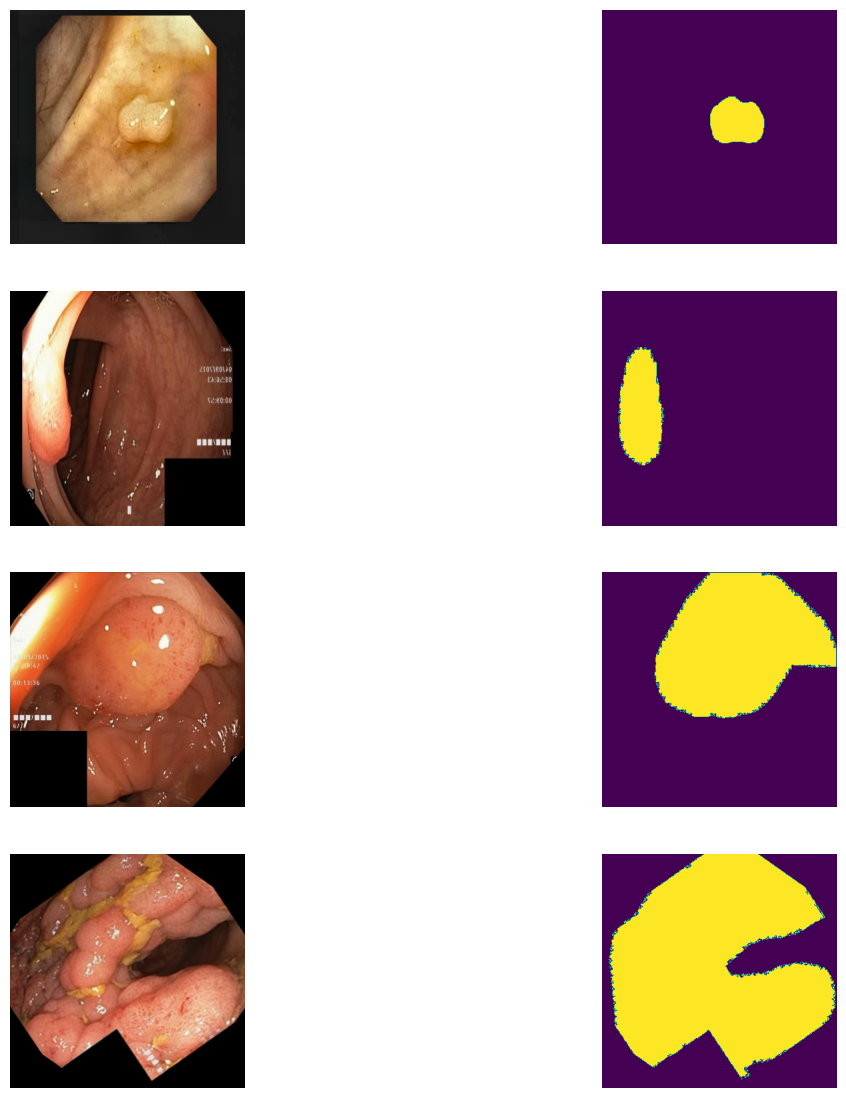

In [ ]:
batch = next(iter(train_loader))

plt.figure(figsize=(14, 14))

for i in range(4): ## batch
    for j in [0, 1]: ## image, mask
        if j==0:
            x = 2*i+1
        else:
            x = 2*i+2

        ax = plt.subplot(4,2, x)
        image = np.moveaxis(np.array(batch[j][i]*255), 0, -1)
        if j==0:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image.astype("uint8"))
        plt.axis("off")

# Color Mapping mask to image

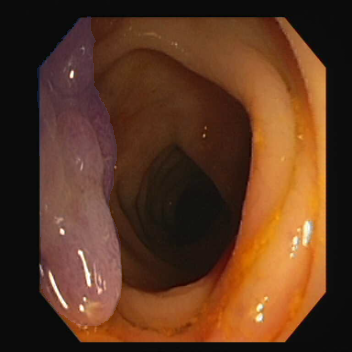

In [ ]:
import random
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

_classes_ = ['polyp']

COLORS = np.random.uniform(0, 255, size=(len(_classes_), 3))
# COLORS = np.array([[0, 255, 255]])
def draw_segmentation_map(image, mask):
    alpha = 1
    beta = 0.15 # transparency for the segmentation map
    gamma = .2 # scalar added to each sum

    red_map = np.zeros_like(mask).astype(np.uint8)
    green_map = np.zeros_like(mask).astype(np.uint8)
    blue_map = np.zeros_like(mask).astype(np.uint8)
    ## apply a randon color mask to each object
    color = COLORS[random.randrange(0, len(COLORS))]
    red_map[mask == 1], green_map[mask == 1], blue_map[mask == 1]  = color
    # combine all the masks into a single image
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    ## convert from RGB to OpenCV BGR format
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    ## apply mask on the image
    cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
    return image

if __name__ == '__main__':
    id=1
    image_path = train_img_path[id]
    mask_path  = train_target_path[id]
    image = cv2.imread(image_path)
    mask  = cv2.imread(mask_path)
    image = cv2.resize(image, img_size)
    mask = cv2.resize(mask, img_size)
    mask = mask[:, :, 0]
    mask = mask/255.
    result = draw_segmentation_map(image, mask)
    cv2_imshow(result)

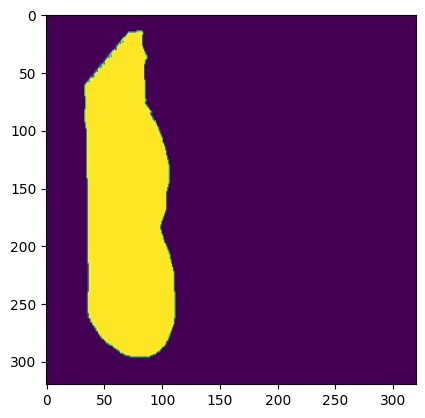

In [ ]:
plt.imshow(mask)

# Train Config

In [ ]:
!pip install torchmetrics
import torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 9.1 MB/s eta 0:00:00


In [ ]:
import sys
import logging
from torch.utils.tensorboard import SummaryWriter

logging.getLogger().setLevel(logging.INFO)
logger = logging.getLogger('Segmentation')
# logger.setLevel(logging.INFO)
writer = SummaryWriter()

In [ ]:
try:
    from google import colab
    COLAB_ENV = True
except (ImportError, ModuleNotFoundError):
    COLAB_ENV = False

# Load the TensorBoard notebook extension
if COLAB_ENV:
    %load_ext tensorboard
    %tensorboard --logdir runs  --host localhost --port 8088
else:
    print("To use tensorboard, please use this notebook in a Google Colab environment.")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 8088 (pid 2096), started 0:03:42 ago. (Use '!kill 2096' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
'''metrics and loss functions'''

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        ##comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class BCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(BCELoss, self).__init__()

    def forward(self, inputs, targets):

        ##comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return BCE

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        ##comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE


def structure_loss(pred, mask):
    weit = 1 + 5 * torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15) - mask)
    wbce = F.binary_cross_entropy_with_logits(pred, mask)
    wbce = (weit * wbce).sum(dim=(2, 3)) / weit.sum(dim=(2, 3))

    pred = torch.sigmoid(pred)
    inter = ((pred * mask) * weit).sum(dim=(2, 3))
    union = ((pred + mask) * weit).sum(dim=(2, 3))
    wiou = 1 - (inter + 1) / (union - inter + 1)

    return torch.mean(wbce + wiou)

def clip_gradient(optimizer, grad_clip):
    """
    For calibrating misalignment gradient via cliping gradient technique
    :param optimizer:
    :param grad_clip:
    :return:
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

## Dice Metric
class Dice(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return dice

## IoU (Jaccard) Metric
class IoU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoU, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum() - intersection.sum()

        jaccard = ((intersection+smooth)/(union + smooth))

        return jaccard

In [ ]:
'''Set Optimizer'''
optimizer = optim.AdamW(net.parameters(), lr=0.0005, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3,
                                                       threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)

In [ ]:
# from torchmetrics.classification import BinaryF1Score, BinaryPrecision, BinaryRecall
# from torchmetrics import Dice

# Training
def train(epoch):
    net.train()
    loss_total = AverageMeter()
    dice_total = AverageMeter()
    iou_total = AverageMeter()

    dice = Dice()
    iou = IoU()
    # Dice_ = Dice().cuda()

    for batch_idx, (inputs, masks) in enumerate(train_loader):
        inputs, masks = inputs.to(device), masks.to(device)
        optimizer.zero_grad()

        # out1, out2, out3, out4 = net(inputs)
        out = net(inputs)

        # # loss1 = criterion(out1, masks)
        # # loss2 = criterion(out2, masks)
        # # loss3 = criterion(out3, masks)
        # # loss4 = criterion(out4, masks)

        # loss1 = structure_loss(out1, masks)
        # loss2 = structure_loss(out2, masks)
        # loss3 = structure_loss(out3, masks)
        # loss4 = structure_loss(out4, masks)

        # a=1;b=1;c=1;d=1
        # loss = a*loss1 + b*loss2 + c*loss3 + d*loss4

        loss = structure_loss(out, masks)
        loss.backward()
        # clip_gradient(optimizer, 0.5)
        optimizer.step()

        loss_total.update(loss)

        ## calculte Dice metric
        # out = out1 + out2 + out3 + out4
        out = F.sigmoid(out)
        # out = (out - torch.min(out))/(torch.max(out)-torch.min(out)

        train_dice = dice(out, masks.type(torch.int64))
        dice_total.update(train_dice)

        train_iou = iou(out, masks.type(torch.int64))
        iou_total.update(train_iou)

        # Dice_(out, masks.type(torch.int64))
    # dice = Dice_.compute()

    writer.add_scalar('Loss/train', loss_total.avg.item(), epoch)
    writer.add_scalar('Dice/train', dice_total.avg.item(), epoch)

    print(f'Train: Epoch[{epoch}]:',
                f'Loss:{loss_total.avg:0.4}',
                f'Dice:{dice_total.avg:0.4}',
                f'IoU:{iou_total.avg:0.4}',
                # f'Dice:{dice:0.4}'
                )


def validation(epoch, checkpoint):
    net.eval()
    test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']
    data=[]
    for dataset_name in test_datasets:
        ## for every dataset the Averagemeter Reset and all the items become clear
        val_loss_total = AverageMeter()
        val_dice_total = AverageMeter()
        val_iou_total = AverageMeter()

        dice = Dice()
        iou = IoU()
        # Dice_ = Dice().cuda()
        val_obj = DataLoader(dataset_name=dataset_name,
                                path='../CASCADE/data/polyp/dataset/TestDataset/',
                                mode='test',
                                transform = False,
                                batch_size=10,
                                image_size=(352,352))

        val_loader = val_obj.create_loader()

        with torch.no_grad():
            for batch_idx, (inputs, masks) in enumerate(val_loader):
                inputs, masks = inputs.to(device), masks.to(device)
                # out1, out2, out3, out4 = net(inputs)
                out = net(inputs)

                if dataset_name =='test':
                    # # loss1 = criterion(out1, masks)
                    # # loss2 = criterion(out2, masks)
                    # # loss3 = criterion(out3, masks)
                    # # loss4 = criterion(out4, masks)

                    # loss1 = structure_loss(out1, masks)
                    # loss2 = structure_loss(out2, masks)
                    # loss3 = structure_loss(out3, masks)
                    # loss4 = structure_loss(out4, masks)

                    # a=1;b=1;c=1;d=1
                    # val_loss = a*loss1 + b*loss2 + c*loss3 + d*loss4

                    val_loss = structure_loss(out, masks)

                    val_loss_total.update(val_loss)

                # out = out1 + out2 + out3 + out4
                out = F.sigmoid(out)
                # out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

                val_dice = dice(out, masks.type(torch.int64))
                val_dice_total.update(val_dice)

                val_iou = iou(out, masks.type(torch.int64))
                val_iou_total.update(val_iou)

                # Dice_(out, masks.type(torch.int64))
            # val_dice = Dice_.compute()

            if dataset_name=='test':
                writer.add_scalar('val_Loss/test', val_loss_total.avg.item(), epoch)
                writer.add_scalar('val_Dice/test', val_dice_total.avg.item(), epoch)
                lr = scheduler.optimizer.param_groups[0]['lr']

                print(f'Valid: Epoch[{epoch}]:',
                            f'loss:{val_loss_total.avg:.4}',
                            # f'Dice:{val_dice:0.4}',
                            f'Dice:{val_dice_total.avg:0.4}',
                            f'IoU:{val_iou_total.avg:0.4}',
                            f'lr:{lr:0.1}',
                     )

                checkpoint.save(val_dice_total.avg, epoch=epoch)
                print(Fore.BLACK + '>>---------------------------------------------------<<')


            else:
                # print(f'Dice [{dataset_name}]:{val_dice_total.avg:0.4}')
                # print(f'{dataset_name}:: Dice:{val_dice_total.avg:0.4}  IoU:{val_iou_total.avg:0.4}')

                data.append([dataset_name, torch.round(val_dice_total.avg, decimals=4), torch.round(val_iou_total.avg, decimals=4)])

    print(tabulate(data, headers=["Dataset", "Dice", "IoU"]))

    print()
    scheduler.step(val_loss_total.avg)

'''Saving weights and paramteres'''
class Checkpoint(object):
    def __init__(self, model_name):
        '''dice = Dice'''
        self.best_dice = 0.
        self.folder = 'checkpoint'
        self.model_name = model_name
        os.makedirs(self.folder, exist_ok=True)
    def save(self, dice, epoch=-1):
        if dice > self.best_dice:
            print(Fore.LIGHTRED_EX + 'INFO: Saving checkpoint...')
            state = {
                'net': net.state_dict(),
                'dice': dice,
                'epoch': epoch,
            }
            path = os.path.join(os.path.abspath(self.folder), self.model_name + '.pth')
            torch.save(state, path)
            self.best_dice = dice
    def load(self, net):
        pass

In [ ]:
writer = SummaryWriter()
checkpoint = Checkpoint('ckpt_pvt2_Decoder_2')
start, end = 1, 30
net = net.to(device)


for epoch in range(start, end+1):
    train(epoch)
    validation(epoch, checkpoint)

writer.close()

Train: Epoch[1]: Loss:1.078 Dice:0.3885 IoU:0.2469
Valid: Epoch[1]: loss:1.071 Dice:0.3459 IoU:0.2137 lr:0.0005
INFO: Saving checkpoint...
>>---------------------------------------------------<<
Dataset              Dice     IoU
-----------------  ------  ------
CVC-300            0.2172  0.1222
CVC-ClinicDB       0.4669  0.3048
Kvasir             0.5062  0.3417
CVC-ColonDB        0.3148  0.1905
ETIS-LaribPolypDB  0.2648  0.154

Train: Epoch[2]: Loss:0.677 Dice:0.6618 IoU:0.5009
Valid: Epoch[2]: loss:0.7739 Dice:0.548 IoU:0.3863 lr:0.0005
INFO: Saving checkpoint...
>>---------------------------------------------------<<
Dataset              Dice     IoU
-----------------  ------  ------
CVC-300            0.4425  0.2886
CVC-ClinicDB       0.6713  0.5123
Kvasir             0.7304  0.5776
CVC-ColonDB        0.4942  0.3362
ETIS-LaribPolypDB  0.4406  0.2943

Train: Epoch[3]: Loss:0.5678 Dice:0.7251 IoU:0.575
Valid: Epoch[3]: loss:0.6293 Dice:0.6353 IoU:0.4763 lr:0.0005
INFO: Saving checkpo

# prediction

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, transforms
from torchvision import transforms

import os
import random
import pandas as pd
import cv2
from glob import glob
import numpy as np
import shutil
from PIL import Image
from matplotlib import pyplot as plt
import albumentations as A

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
## load model
PATH = '/content/drive/MyDrive/polyp/checkpoint/ckpt_pvt2_Decoder_2.pth'
model = Polyp_Net()
model.load_state_dict(torch.load(PATH, map_location=device)['net'])
model.eval()

In [ ]:
dice = torch.load(PATH, map_location=device)['dice']
print(f'validation Dice: {dice:0.2}')

validation Dice: 0.77


In [ ]:
!pip install torchmetrics
import torchmetrics

In [ ]:
class Dice(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(Dice, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return dice

Dice: 0.9283687472343445




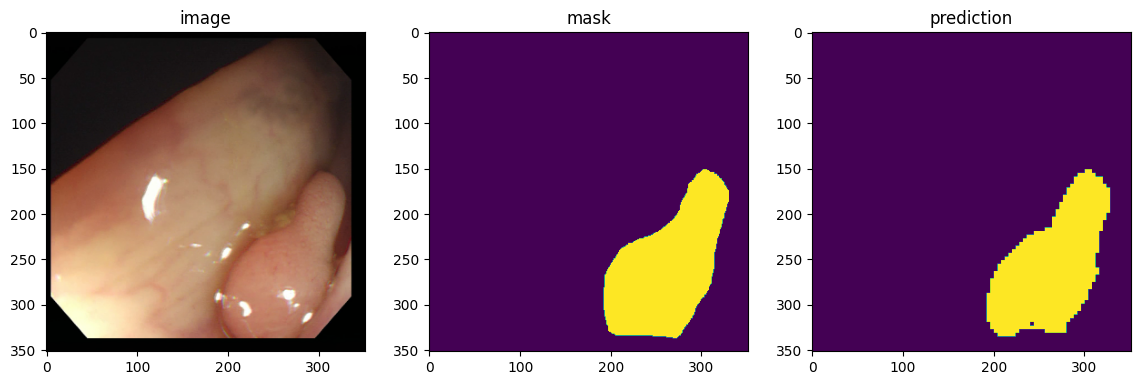

In [ ]:
# from torchmetrics import Dice

## preprocessing an image
def _load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size[1], image_size[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def _load_mask(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size[1], image_size[0]))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,mask = cv2.threshold(gray,254,255,cv2.THRESH_BINARY)
    return np.expand_dims(mask, axis=-1)

def _totensor(tensor):
    totensor = transforms.Compose([transforms.ToTensor()]) ## convert NHWC to NCHW and resacaled to [0,1]
    return totensor(tensor)


if __name__ == "__main__":
    test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']
    # path='../CASCADE/data/polyp/dataset/TrainDataset/'
    path='../CASCADE/data/polyp/dataset/TestDataset/'
    image_size=(352,352)

    # Dice_ = Dice().to(device)

    idx=0
    images = sorted(glob(path+test_datasets[idx]+'/images/*'))
    targets = sorted(glob(path+test_datasets[idx]+'/masks/*'))

    id=100
    loaded_image = _load_image(images[id])
    image = _totensor(loaded_image)
    image = image.unsqueeze(dim=0)

    target = _load_mask(targets[id])
    target = _totensor(target)
    target = target.unsqueeze(dim=0)

    # out1, out2, out3, out4 = model(image)
    # out = out1 + out2 + out3 + out4
    # out = torch.sigmoid(out)
    # out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

    out = model(image)
    out = torch.sigmoid(out)

    dice = Dice()
    dice_score = dice(out, target.type(torch.int64))
    # dice = Dice_(out, target.type(torch.int64))
    # dice = Dice_.compute()
    print(f'Dice: {dice_score}')
    print('\n')

    ## convert torch tensor to numpy array
    pred = torch.permute(out, (0,2,3,1)) ## NCHW
    pred = pred.detach().numpy()
    pred = np.squeeze(pred, axis=0)      ## HWC
    pred = pred*255
    _,pred = cv2.threshold(pred,200,255,cv2.THRESH_BINARY)
    pred = pred.astype(np.uint8)

    # mask = mask/255.
    mask = torch.permute(target, (0,2,3,1)) ## NCHW
    mask = mask.detach().numpy()
    mask = np.squeeze(mask, axis=0)      ## HWC
    mask = mask*255
    mask = mask.astype(np.uint8)

    plt.figure(figsize=(14,14))
    plt.subplot(1,3,1)
    plt.imshow(loaded_image)
    plt.title('image')
    plt.subplot(1,3,2)
    plt.imshow(mask)
    plt.title('mask')
    plt.subplot(1,3,3)
    plt.imshow(pred)
    plt.title('prediction')


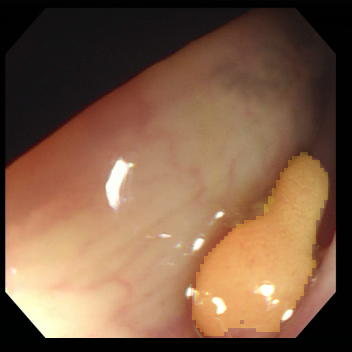

In [ ]:
import random
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

_classes_ = ['polyp']

# COLORS = np.random.uniform(0, 255, size=(len(_classes_), 3))
COLORS = np.array([[0, 255, 255]])
def draw_segmentation_map(image, mask):
    alpha = 1
    beta = 0.15 # transparency for the segmentation map
    gamma = .2 # scalar added to each sum

    red_map = np.zeros_like(mask).astype(np.uint8)
    green_map = np.zeros_like(mask).astype(np.uint8)
    blue_map = np.zeros_like(mask).astype(np.uint8)
    ## apply a randon color mask to each object
    color = COLORS[random.randrange(0, len(COLORS))]
    red_map[mask == 1], green_map[mask == 1], blue_map[mask == 1]  = color
    # combine all the masks into a single image
    segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
    ## convert from RGB to OpenCV BGR format
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    ## apply mask on the image
    cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
    return image

if __name__ == '__main__':
    id=100
    loaded_image = _load_image(images[id])
    loaded_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2RGB)

    target = _load_mask(targets[id])
    target = _totensor(target)
    target = target.unsqueeze(dim=0)

    ## conver torch tensor to numpy array
    pred = torch.permute(out, (0,2,3,1)) ## NCHW
    pred = pred.detach().numpy()
    pred = np.squeeze(pred, axis=0)      ## HWC
    pred = pred*255
    _,pred = cv2.threshold(pred,200,255,cv2.THRESH_BINARY)
    pred = pred.astype(np.uint8)

    # mask = mask/255.
    # mask = torch.permute(target, (0,2,3,1)) ## NCHW
    # mask = mask.detach().numpy()
    # mask = np.squeeze(mask, axis=0)      ## HWC
    # mask = mask*255
    # mask = mask.astype(np.uint8)

    # mask = mask[:, :, 0]
    mask = pred
    mask = mask/255.
    result = draw_segmentation_map(loaded_image, mask)
    cv2_imshow(result)

Dice[image1]: 0.9028475880622864
Dice[image2]: 0.7895480394363403
Dice[image3]: 0.8628300428390503
Dice[image4]: 0.0
Dice[image5]: 0.9023110270500183


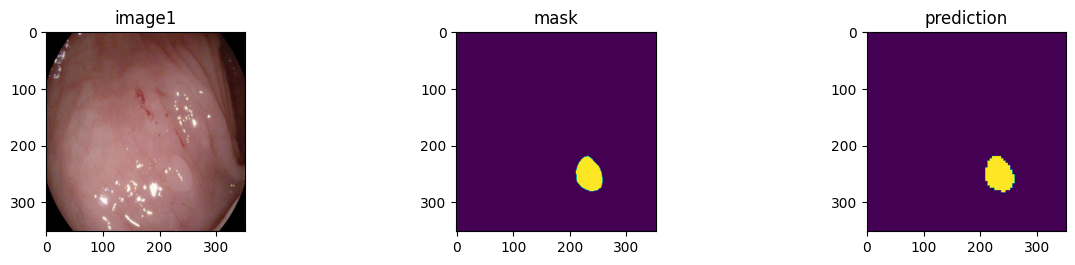

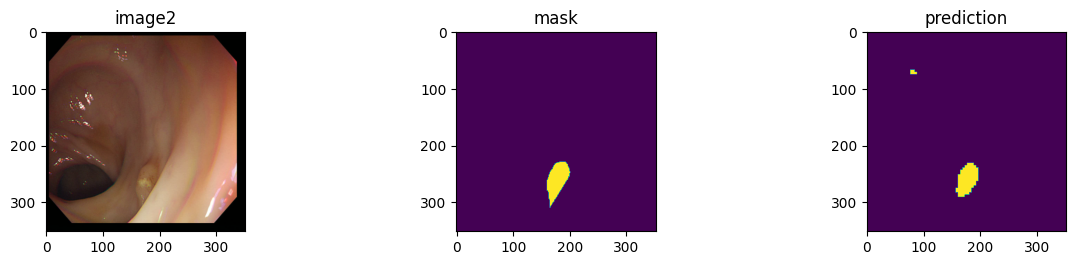

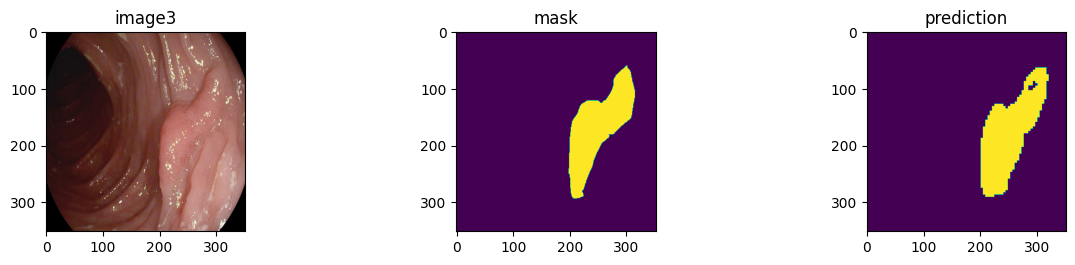

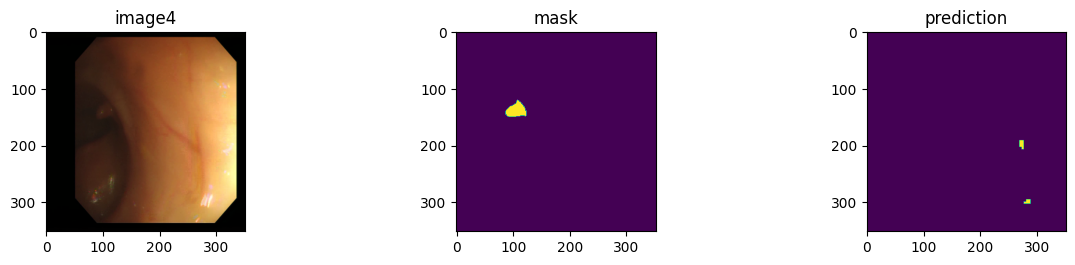

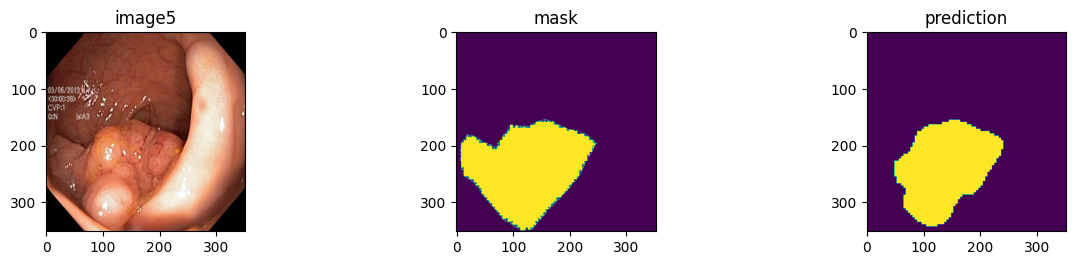

In [ ]:
from torchmetrics import Dice
## preprocessing an image
def _load_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size[1], image_size[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def _load_mask(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size[1], image_size[0]))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,mask = cv2.threshold(gray,254,255,cv2.THRESH_BINARY)
    return np.expand_dims(mask, axis=-1)

def _totensor(tensor):
    totensor = transforms.Compose([transforms.ToTensor()]) ## convert NHWC to NCHW and resacaled to [0,1]
    return totensor(tensor)


test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']
# path='../CASCADE/data/polyp/dataset/TrainDataset/'
path='../CASCADE/data/polyp/dataset/TestDataset/'
image_size=(352,352)

# Dice_ = Dice().to(device)

idx=0
images = sorted(glob(path+test_datasets[idx]+'/images/*'))
targets = sorted(glob(path+test_datasets[idx]+'/masks/*'))

import random
n=5
r = random.sample(range(0, len(targets)), n)

for k, id in enumerate(r):
    loaded_image = _load_image(images[id])
    image = _totensor(loaded_image)
    image = image.unsqueeze(dim=0)

    target = _load_mask(targets[id])
    target = _totensor(target)
    target = target.unsqueeze(dim=0)

    # out1, out2, out3, out4 = model(image)
    # out = out1 + out2 + out3 + out4
    # out = torch.sigmoid(out)
    # out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

    out = model(image)
    out = torch.sigmoid(out)

    dice = Dice()
    dice_score = dice(out, target.type(torch.int64))

    # dice = Dice_(out, target.type(torch.int64))
    print(f'Dice[image{k+1}]: {dice_score}')

    ## conver torch tensor to numpy array
    pred = torch.permute(out, (0,2,3,1)) ## NCHW
    pred = pred.detach().numpy()
    pred = np.squeeze(pred, axis=0)      ## HWC
    pred = np.where(pred >= 200/255, 1, 0)
    pred = pred*255
    pred = pred.astype(np.uint8)

    # mask = mask/255.
    mask = torch.permute(target, (0,2,3,1)) ## NCHW
    mask = mask.detach().numpy()
    mask = np.squeeze(mask, axis=0)      ## HWC
    mask = mask*255
    mask = mask.astype(np.uint8)

    plt.figure(figsize=(15,15))
    plt.subplot(n,3,1)
    plt.imshow(loaded_image)
    plt.title('image'+str(k+1))
    plt.subplot(n,3,2)
    plt.imshow(mask)
    plt.title('mask')
    plt.subplot(n,3,3)
    plt.imshow(pred)
    plt.title('prediction')

# Test all images by the model

In [ ]:
## travelling on train dataset
from tqdm import tqdm

path='../CASCADE/data/polyp/dataset/TrainDataset/'
image_size=(352,352)

Dice_ = Dice().to(device)

images = sorted(glob(path+'images/*'))
targets = sorted(glob(path+'masks/*'))

dice_dict={}
for idx in tqdm(range(len(images)), ncols = 100, desc='train-set evaluation:'):
    loaded_image = _load_image(images[idx])
    image = _totensor(loaded_image)
    image = image.unsqueeze(dim=0)

    target = _load_mask(targets[idx])
    target = _totensor(target)
    target = target.unsqueeze(dim=0)

    out1, out2, out3, out4 = model(image)
    out = out1 + out2 + out3 + out4
    out = torch.sigmoid(out)
    out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

    dice = Dice_(out, target.type(torch.int64))

    dice_dict[images[idx].split('/')[-1]]=dice

train-set evaluation:: 100%|████████████████████████████████████| 1450/1450 [32:57<00:00,  1.36s/it]


In [ ]:
d = {k: v for k, v in sorted(dice_dict.items(), key=lambda item: item[1])}
d.values()

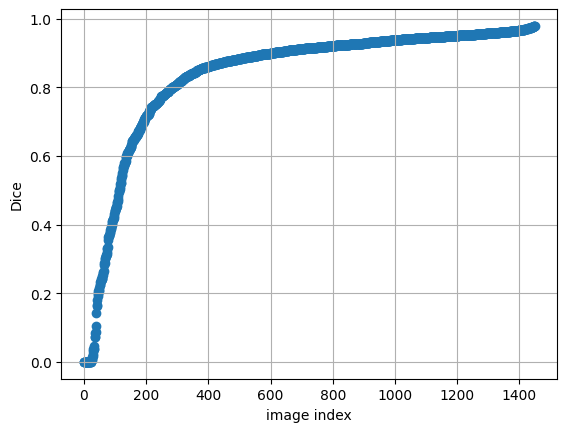

In [ ]:
'''300 sample images is under 80% Dice score
   200 sample images is under 70% Dice score
   100 sample images is under 40% dice score
'''
values = [k.item() for k in d.values()]
values
index = [i for i in range(len(values))]
plt.scatter(index, values)
plt.ylabel('Dice')
plt.xlabel('image index')
plt.grid()

plt.show()

In [ ]:
import csv

with open('dice_dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in d.items():
       writer.writerow([key, value.item()])

In [ ]:
values_ = [k.item() for k in d.values()]
keys_ = [k for k in d.keys()]

dd={}
dd['ids']=keys_
dd['dice']=values
df = pd.DataFrame(dd)

,ids,dice
0,125.png,0.000000
1,126.png,0.000000
2,135.png,0.000000
3,188.png,0.000000
4,204.png,0.000000
...,...,...
1445,138.png,0.976646
1446,cju8dn0c3u2v50801k8rvq02f.png,0.976777
1447,cju2xf8e5y2wm08359vcgk09b.png,0.976923
1448,cju3wstckialg0871xs0vevsj.png,0.977639


In [ ]:
# df.to_csv('dice_dict.zip', index=False)

In [ ]:
pd.read_csv('dice_dict.csv')

In [ ]:
## travelling on test dataset
## I want to find which dataset has the worse relut on my model
## according to my test dataset the CVC-ColonDB give the worst Dice
## So we trace on the model and find the problem and why?????


from tqdm import tqdm

path='../CASCADE/data/polyp/dataset/TestDataset/'
image_size=(352,352)

Dice_ = Dice().to(device)

images = sorted(glob(path+test_datasets[idx]+'/images/*'))
targets = sorted(glob(path+test_datasets[idx]+'/masks/*'))

dice_dict_test={}
for idx in tqdm(range(len(images)), ncols = 100, desc='test-set evaluation:'):
    loaded_image = _load_image(images[idx])
    image = _totensor(loaded_image)
    image = image.unsqueeze(dim=0)

    target = _load_mask(targets[idx])
    target = _totensor(target)
    target = target.unsqueeze(dim=0)

    out1, out2, out3, out4 = model(image)
    out = out1 + out2 + out3 + out4
    out = torch.sigmoid(out)
    out = (out - torch.min(out))/(torch.max(out)-torch.min(out))

    dice = Dice_(out, target.type(torch.int64))

    dice_dict_test[images[idx].split('/')[-1]]=dice.item()

test-set evaluation:: 100%|███████████████████████████████████████| 798/798 [18:42<00:00,  1.41s/it]


In [ ]:
dice_dict_test

In [ ]:
d_test = {k: v for k, v in sorted(dice_dict_test.items(), key=lambda item: item[1])}
d_test.values()

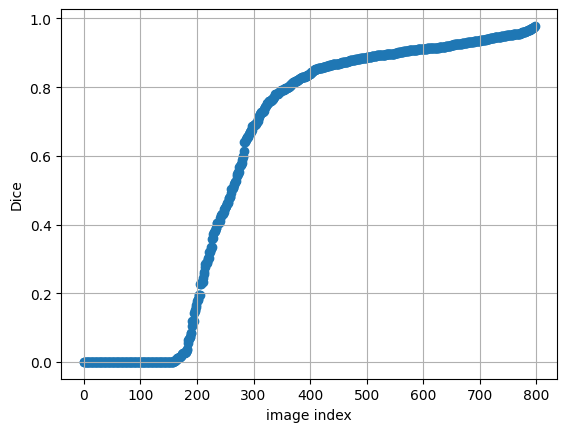

In [ ]:
'''300 sample images is under 70% Dice score
   200 sample images is under 20% Dice score
'''
values = [k for k in d_test.values()]
values
index = [i for i in range(len(values))]
plt.scatter(index, values)
plt.ylabel('Dice')
plt.xlabel('image index')
plt.grid()

plt.show()

In [ ]:
d_counter_test={}
a=0;b=0;c=0;d=0;e=0

for key, val in d_test.items():
    if val < 0.4:
        if 'ETIS-LaribPolypDB' in key:
            a+=1
            d_counter_test['ETIS-LaribPolypDB']=a
        elif 'CVC-300' in key:
            b+=1
            d_counter_test['CVC-300']=b
        elif 'CVC-ColonDB' in key:
            c+=1
            d_counter_test['CVC-ColonDB']=c
        elif 'CVC-ClinicDB' in key:
            d+=1
            d_counter_test['CVC-ClinicDB']=d
        elif 'Kvasir' in key:
            e+=1
            d_counter_test['Kvasir']=e


In [ ]:
d_counter_test   ### the worst results is considered on CVC-ColonDB with 167/235

{'ETIS-LaribPolypDB': 31,
 'CVC-ColonDB': 167,
 'CVC-300': 15,
 'CVC-ClinicDB': 14,
 'Kvasir': 8}

In [ ]:
d_test

In [ ]:
path='../CASCADE/data/polyp/dataset/TestDataset/'
test_datasets = ['test', 'CVC-300', 'CVC-ClinicDB', 'Kvasir', 'CVC-ColonDB', 'ETIS-LaribPolypDB']

images = sorted(glob(path+test_datasets[1]+'/images/*'))
targets = sorted(glob(path+test_datasets[-2]+'/masks/*'))

len(images)

60